In [1]:
import os
import random
import numpy as np
import pandas as pd

from PIL import Image
from shutil import copyfile
from matplotlib import pyplot as plt

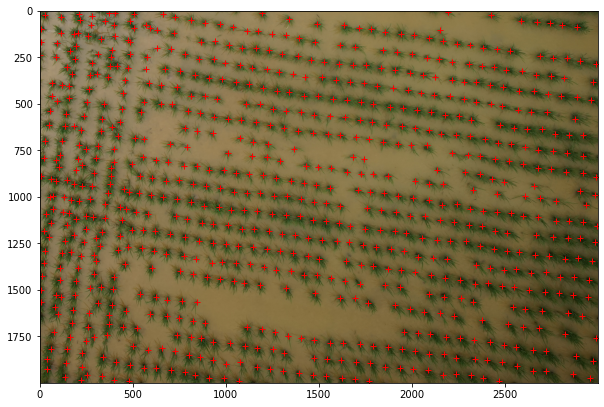

In [2]:
img = Image.open('./Train_Dev/training/DSC080454.JPG')
labels = []

with open(r'Train_Dev\train_labels\DSC080454.csv', 'r') as f:
    lines = f.readlines()
for line in lines:
    x, y = tuple(line.strip().split(','))
    labels.append((int(x),int(y)))

plt.figure(figsize=(10,10))
plt.imshow(img)
for label in labels:
    plt.plot(*label, 'r+')

total: 755


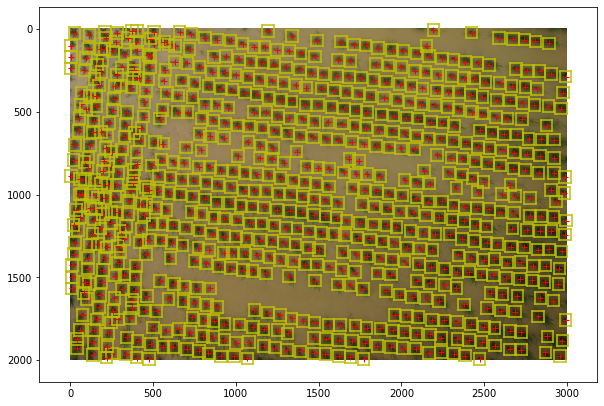

In [5]:
w, h = 35, 35

plt.figure(figsize=(10,10))
plt.imshow(img)
for label in labels:
    x, y = label
    plt.plot([x-w, x+w], [y-h, y-h], 'y-')
    plt.plot([x-w, x+w], [y+h, y+h], 'y-')
    plt.plot([x-w, x-w], [y-h, y+h], 'y-')
    plt.plot([x+w, x+w], [y-h, y+h], 'y-')
    plt.plot(x, y, 'r+')
print('total: {}'.format(len(labels)))

In [8]:
def csv_to_yolo(csv_path, img_path, dest_path, box_size = None):

    assert os.path.isfile(csv_path), 'No such file or directory: \'{}\''.format(csv_path)
    assert os.path.isfile(img_path), 'No such file or directory: \'{}\''.format(img_path)

    if not box_size:
        box_width, box_height = 35, 35 # default box size
    elif isinstance(box_size, int):
        box_width = box_height = box_size
    elif isinstance(box_size, tuple) and len(box_size) == 2:
        if (not isinstance(box_size[0], int)) or (not isinstance(box_size[1], int)):
            raise TypeError('expect tuple (int, int) but get ({}, {})'.format(type(box_size[0]), type(box_size[1])))
        else:
            box_width, box_height = box_size
    else:
        raise TypeError('box_size should be (int, int) or int but get {}'.format(type(box_size)))


    with open(csv_path, 'r') as f:
        lines = f.readlines()
    
    labels = []

    for line in lines:
        x, y = line.strip().split(',')
        labels.append((int(x),int(y)))

    img = Image.open(img_path)
    img_width, img_hieght = img.size

    data = []

    # class, x_center, y_center, box_width, box_height
    for x, y in labels:
        data.append([0, x/img_width, y/img_hieght, box_width/img_width, box_height/img_width])

    np.savetxt(dest_path, np.asarray(data), fmt = '%d %f %f %f %f')

In [9]:
out_data_path = './RiceField'

# if RiceField exist, create RiceField0, RiceField1...
name_cnt = 0
while os.path.isdir(out_data_path):
    out_data_path = out_data_path + str(name_cnt)
    name_cnt+=1


'''
./RiceField/
    /images/
        /valid/
            *.jpg
        /train/
            *.jpg
    /labels/
        /valid/
            *.csv
        /train/
            *.csv
'''

out_images_dir = os.path.join(out_data_path, 'images')
out_labels_dir = os.path.join(out_data_path, 'labels')

os.mkdir(out_data_path)
os.mkdir(out_images_dir)
os.mkdir(out_labels_dir)
os.mkdir(os.path.join(out_images_dir, 'train'))
os.mkdir(os.path.join(out_images_dir, 'valid'))
os.mkdir(os.path.join(out_labels_dir, 'train'))
os.mkdir(os.path.join(out_labels_dir, 'valid'))

# training_dir: training images
# label_dir: label csv files
training_dir = './Train_Dev/training'
label_dir = './Train_Dev/train_labels'

image_filenames, label_filenames = [], []

for filename in os.listdir(training_dir):
    image_filenames.append(filename)
    label_filenames.append(filename.split('.')[0] + '.csv')

c = list(zip(image_filenames, label_filenames))
random.shuffle(c)
image_filenames, label_filenames = zip(*c)

# take 20% validation 80% training
split_point = int(len(image_filenames)*0.8)

train_image_filenames, train_label_filenames = image_filenames[:split_point], label_filenames[:split_point]
valid_image_filenames, valid_label_filenames = image_filenames[split_point:], label_filenames[split_point:]

for filename in train_image_filenames:
    copyfile(os.path.join(training_dir, filename), os.path.join(out_images_dir, 'train', filename))
for filename in valid_image_filenames:
    copyfile(os.path.join(training_dir, filename), os.path.join(out_images_dir, 'valid', filename))

for filename in train_label_filenames:
    csv_to_yolo(
        csv_path = os.path.join(label_dir, filename),
        img_path = os.path.join(training_dir, filename.split('.')[0] + '.JPG'),
        dest_path = os.path.join(out_labels_dir, 'train', filename.split('.')[0] + '.txt'),
    )
for filename in valid_label_filenames:
    csv_to_yolo(
        csv_path = os.path.join(label_dir, filename),
        img_path = os.path.join(training_dir, filename.split('.')[0] + '.JPG'),
        dest_path = os.path.join(out_labels_dir, 'valid', filename.split('.')[0] + '.txt'),
    )